<a href="https://colab.research.google.com/github/pedroblossbraga/supportvectormachines_tcc/blob/master/TCC_SVC_kernelized_02072022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft Margin kernelized SVC

- main reference: https://www.youtube.com/watch?v=gBTtR0bs-1k
- https://github.com/aladdinpersson/Machine-Learning-Collection


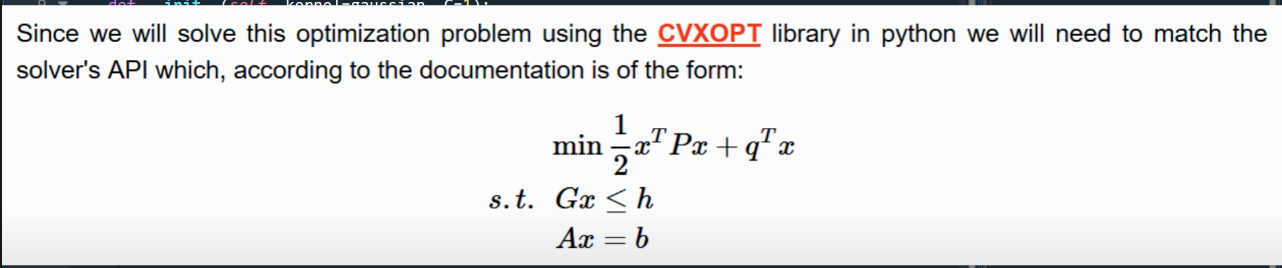

\begin{equation}
\min \frac{1}{2} x^TPx + q^Tx \\
\text{s.a. } Gx \leq h \\
Ax = b
\end{equation}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt

In [ ]:
from sklearn import datasets

X, y = datasets.make_blobs(
    n_samples=250, n_features=2, centers=2, cluster_std=1.05, random_state=1
)

In [ ]:
def gaussian(x, z, sigma=0.1):
  return np.exp(-np.linalg.norm(x-z, axis=1)**2 / (2*(sigma ** 2)))

def linear(x, z):
    return np.dot(x, z.T)

def polynomial(x, z, p=5):
    return (1 + np.dot(x, z.T)) ** p

def tanh(x, z, a=1, b=-1):
    return np.tanh(a * np.dot(x, z.T) + b)

In [ ]:
class SVC_kernelized():
  def __init__(self, kernel=gaussian, C=1):
    self.kernel = kernel
    self.C = C

  def fit(self, X, y):
    self.y = y
    self.X = X
    m, n = X.shape

    # Calculate Kernel
    self.K = np.zeros((m, m))
    for i in range(m):
      self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)

    # Solve with cvxopt final QP needs to be reformulated
    # to match the input form for cvxopt.solvers.qp
    P = cvxopt.matrix(np.outer(y, y) * self.K)
    q = cvxopt.matrix(-np.ones((m, 1)))
    G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
    h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
    A = cvxopt.matrix(y, (1, m), "d")
    b = cvxopt.matrix(np.zeros(1))
    cvxopt.solvers.options["show_progress"] = False
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    self.alphas = np.array(sol["x"])

  def predict(self, X):
    y_predict = np.zeros((X.shape[0]))
    sv = self.get_parameters(self.alphas)

    for i in range(X.shape[0]):
      y_predict[i] = np.sum(
          self.alphas[sv]
          * self.y[sv, np.newaxis]
          * self.kernel(X[i], self.X[sv])[:, np.newaxis]
      )

    return np.sign(y_predict + self.b)

  def get_parameters(self, alphas):
    threshold = 1e-5

    sv = ((alphas > threshold) * (alphas < self.C)).flatten()
    self.w = np.dot(X[sv].T, alphas[sv] * self.y[sv, np.newaxis])
    self.b = np.mean(
      self.y[sv, np.newaxis]
      - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis]
    )
    return sv


In [ ]:
def plot_contour(X, y, svm, kernel_name, acc):
  # plot the resulting classifier
  h = 0.01
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  points = np.c_[xx.ravel(), yy.ravel()]

  Z = svm.predict(points)
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

  # plt the points
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
  plt.title(f'Kernel: {kernel_name}, accuracy: {acc}', fontsize = 15)
  plt.show()

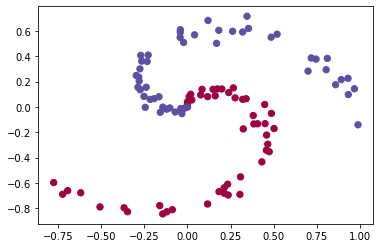

In [ ]:
def create_dataset(N, D=2, K=2):
  X = np.zeros((N * K, D))  # data matrix (each row = single example)
  y = np.zeros(N * K)  # class labels

  for j in range(K):
      ix = range(N * j, N * (j + 1))
      r = np.linspace(0.0, 1, N)  # radius
      t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
      X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
      y[ix] = j

  # lets visualize the data:
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
  plt.show()

  y[y == 0] -= 1

  return X, y

X, y = create_dataset(N=50)


In [ ]:
np.random.seed(42)

def plot_estimation(kernel, kernel_name):
  clf = SVC_kernelized(kernel=kernel)
  clf.fit(X,y)
  y_pred = clf.predict(X)

  acc = sum(y==y_pred)/y.shape[0]
  print(f"Accuracy: {acc}")

  plot_contour(X, y, clf, kernel_name, acc)


Accuracy: 0.99


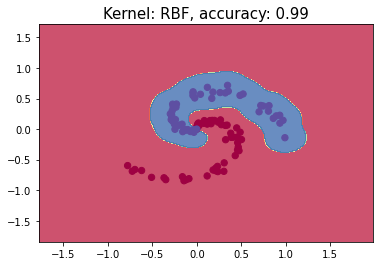

In [ ]:
plot_estimation(kernel=gaussian, kernel_name='RBF')

Accuracy: 0.74


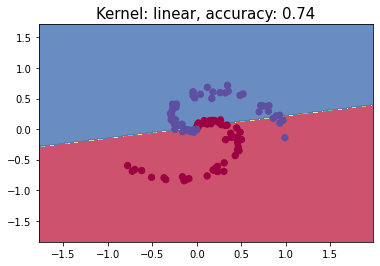

In [ ]:
plot_estimation(kernel=linear, kernel_name='linear')

Accuracy: 0.98


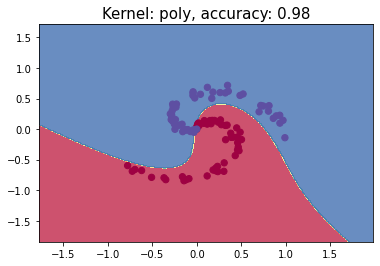

In [ ]:
plot_estimation(kernel=polynomial, kernel_name='poly')

Accuracy: 0.79


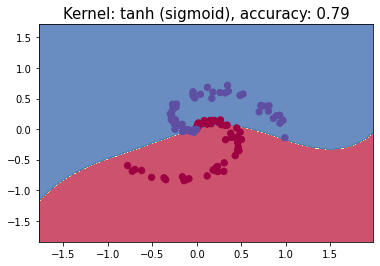

In [ ]:
plot_estimation(kernel=tanh, kernel_name='tanh (sigmoid)')

In [ ]:
def plot_contour2(X, y, svm, kernel_name, acc, 
                  params = None,
                  params_str=''):
  # plot the resulting classifier
  h = 0.01
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  points = np.c_[xx.ravel(), yy.ravel()]

  Z = svm.predict(points)
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

  # plt the points
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

  if params is not None:
    params_str = f', params: {params}'
  plt.title(f'Kernel: {kernel_name}{params_str}, accuracy: {acc}', 
            fontsize = 15)
  # plt.show()
  return plt

In [ ]:
np.random.seed(42)
def plot_estimation2(kernel, kernel_name, params=None):
  clf = SVC_kernelized(kernel=kernel)
  clf.fit(X,y)
  y_pred = clf.predict(X)

  acc = sum(y==y_pred)/y.shape[0]
  print(f"Accuracy: {acc}")

  plt = plot_contour2(X, y, clf, kernel_name, acc, params)
  return plt

Accuracy: 0.99
Accuracy: 0.74
Accuracy: 0.98
Accuracy: 0.79


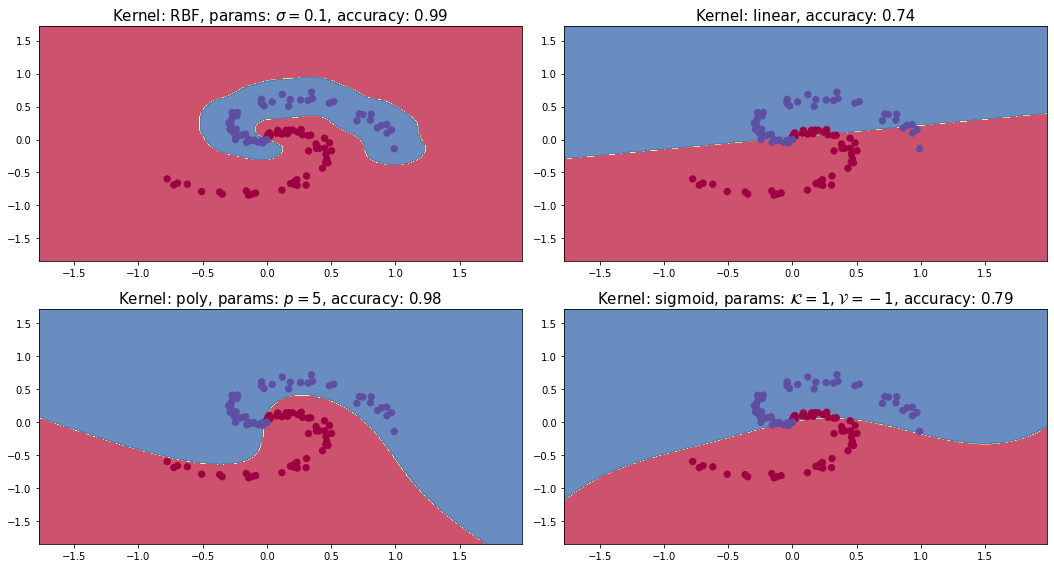

In [ ]:
plt.figure(figsize = (15, 8))
plt.subplot(2,2,1)
fig = plot_estimation2(kernel=gaussian, 
                       kernel_name='RBF',
                       params = r'$\sigma=0.1$')
plt.subplot(2,2,2)
fig = plot_estimation2(kernel=linear, 
                      kernel_name='linear')
plt.subplot(2,2,3)
fig = plot_estimation2(kernel=polynomial, 
                      kernel_name='poly',
                      params = r'$p=5$')
plt.subplot(2,2,4)
fig = plot_estimation2(kernel=tanh, 
                      kernel_name='sigmoid', 
                      params  = r'$\mathcal{K}=1, \mathcal{V}=-1$')

plt.tight_layout()
plt.show()